# Vulnerability Analysis and Defense Generation using AIShield SDK
* <b>File Name</b>                          : PyPi_Extraction_Reference_Implementation_MNIST.ipynb
* <b>Date of creation(dd-mm-yyyy)</b>       : 01-04-2023
* <b>Author Name/Dept</b>                   : AIShield
* <b>Organization</b>                       : BGSW
* <b>Description</b>                        : Source Code of Reference Implementation
* <b>Copyright</b>                          : Copyright 2022 Bosch Global Software Technologies Private Limited. All Rights Reserved.

### Input
This Example does the following:
* Downloads the MNIST-Dataset from Tensorflow-Datasets
* Trains a Tensorflow Model for Image Classification on the MNIST Dataset
* Trained Model File : "mnist_model.h5"

### Output and Artifacts
1. Vulnerability report
2. Defense report
3. Defense model
4. attack samples

In [9]:
"""
Description: commands to install all the packages
"""
%pip install mlflow==2.2.2
%pip install tensorflow==2.9.1
%pip install opencv-python
%pip install aishield

1.0 Importing libraries

In [0]:
"""
Description: Import libraries
"""
import aishield as ais   # importing AIShield pypi package 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
import zipfile 
import pandas as pd
import cv2
import os
import random
import requests
import json
import time
from tqdm import tqdm
import shutil
#from humanfriendly import format_timespan
from datetime import datetime
import mlflow
from mlflow.utils.environment import _mlflow_conda_env
import cloudpickle
import mlflow.sklearn
import sklearn

2.0 Data Loading and Preprocessing

In [0]:
'''
Description : Loading mnist dataset
'''
(X_train,y_train),(X_test,y_test)=tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [0]:
'''
Description : Splitting data for validation
'''
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,stratify = y_train,test_size = 0.1,random_state = 42)

In [0]:
'''
Description : Check size of dataset
'''
print("shape of x_train: ",X_train.shape)
print("shape of y_train: {}".format(y_train.shape))
print(f'shape of x_test: {X_test.shape}')
print(f'shape of y_test: {y_test.shape}')
print(f'shape of x_val: {X_val.shape}')
print(f'shape of y_val: {y_val.shape}')

shape of x_train:  (54000, 28, 28)
shape of y_train: (54000,)
shape of x_test: (10000, 28, 28)
shape of y_test: (10000,)
shape of x_val: (6000, 28, 28)
shape of y_val: (6000,)


In [0]:
def plot(x, y=None, row: int = 2):
    """
    to visualize random sample
    """
    rows = row
    random_indices = random.sample(range(x.shape[0]), rows * rows)
    sample_images = x[random_indices, :]
    if y is not None:
        sample_labels = y[random_indices]

    fig, axs = plt.subplots(nrows=rows, ncols=rows, figsize=(12, 9), sharex=True, sharey=True)
    for i in range(rows * rows):
        subplot_row = i // rows
        subplot_col = i % rows
        axs[subplot_row, subplot_col].imshow(sample_images[i, :])
        if y is not None:
            axs[subplot_row, subplot_col].set_title("Class. %d" % sample_labels[i])
    plt.tight_layout()
    plt.show()

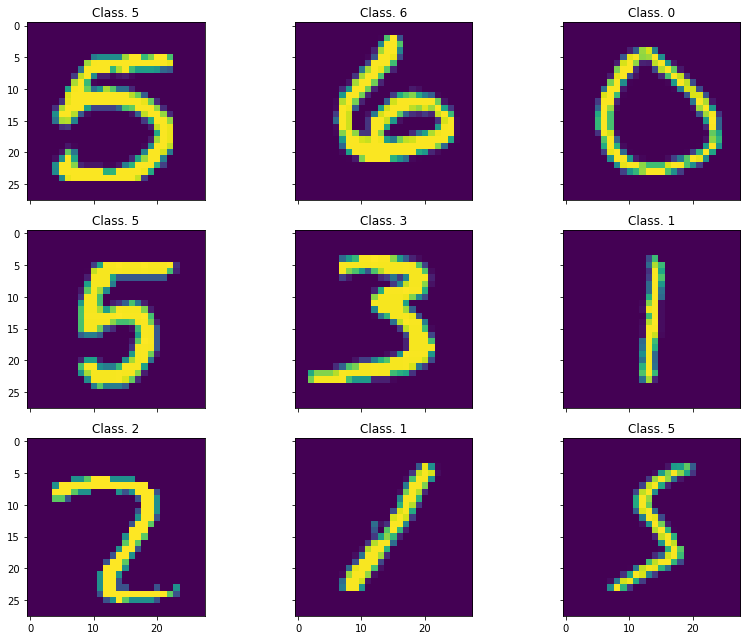

In [0]:
"""
Description: visualize data
"""
plot(X_train, y_train, row=3)

In [0]:
'''
Description : Set num_classes and input shape 
'''
img_row,img_col,channel=28,28,1
num_classes=10
input_shape=(img_row,img_col,channel)

In [0]:
"""
Description: Normalizing and reshaping the data
"""
X_train = X_train.reshape(-1,*input_shape)/255.0
X_val =  X_val.reshape(-1,*input_shape)/255.0
X_test =  X_test.reshape(-1,*input_shape)/255.0

In [0]:
"""
Description : Convert label to one hot encoder
"""
y_train=tf.keras.utils.to_categorical(y_train,num_classes)
y_test=tf.keras.utils.to_categorical(y_test,num_classes)

d 3.0 Model Development and Training

In [0]:
def make_directory(directory):
    """
    create directory

    Parameters
    ----------
    directorys : list containing the directorys path to create 
    Returns
    -------
    None.

    """
    for d in directory:
        if os.path.isdir(d):
            print("directory {} already exist".format(d))
        if os.path.isdir(d)==False:
            os.mkdir(path=d)
            print("directory {} created successfully".format(d))

In [0]:
def delete_directory(directorys):
    """
    delete directory 

    Parameters
    ----------
    directorys : list containing the directorys to deleate along with all the files

    Returns
    -------
    None.

    """
    if len(directorys)>=1:
        for d in directorys:
            if os.path.isdir(d):
                try:
                    if os.path.isfile(d):
                        os.remove(path=d)
                    else:
                        shutil.rmtree(path=d)
                        print("Removed: {}".format(d))
                except:
                    print("Failed to removed: {}".format(d))

In [0]:
def make_archive(base_name,root_dir,zip_format='zip'):
    """
    created zip for given folder

    Parameters
    ----------
    base_name : name of zip file
    root_dir : directory to archive/zip
    zip_format : zip or tar 
        DESCRIPTION. The default is 'zip'.

    Returns
    -------
    None.

    """
    shutil.make_archive(base_name=base_name, format=zip_format, root_dir=root_dir)

In [0]:
def get_file_path(path):
    """
    To get full file path from directory and child directory
    Args:
        path: Directory path

    Returns: list containing full path of all the file from the given directory

    """
    list_id = []
    for (root, dirs, files) in os.walk(path, topdown=True):
        if len(dirs) == 0:
            for file in files:
                list_id.append(os.path.join(root, file))
    return list_id

In [0]:
"""
Description : Create data, model and label folder
"""
mnist_data_path = os.path.join(os.getcwd(), "dataais1")
mnist_model_path = os.path.join(os.getcwd(), "modelais1")
mnist_label_path = os.path.join(os.getcwd(), "labelais1")
zip_path = os.path.join(os.getcwd(), "zipais1")
#pyc_model_path = os.path.join(os.getcwd(), "pyc_model")
report_path = os.path.join(os.getcwd(), "reportsais1")
sample_data = os.path.join(report_path, "sample_data_ais1")
defense_artifact = os.path.join(report_path, "defense_artifactais1")
#deleting folder
delete_directory(
    directorys=[mnist_data_path, mnist_model_path, mnist_label_path, zip_path, report_path])

# # creating folder
make_directory([mnist_data_path, mnist_model_path, mnist_label_path, zip_path, report_path, sample_data,defense_artifact])

directory /databricks/driver/dataais1 created successfully
directory /databricks/driver/modelais1 created successfully
directory /databricks/driver/labelais1 created successfully
directory /databricks/driver/zipais1 created successfully
directory /databricks/driver/reportsais1 created successfully
directory /databricks/driver/reportsais1/sample_data_ais1 created successfully
directory /databricks/driver/reportsais1/defense_artifactais1 created successfully


In [0]:
def cnn_model(input_shape=input_shape, num_classes=num_classes):
    """
    Description: Create model architecture
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu', input_shape=input_shape),
        tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(strides=(2,2)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')  
    ])
    #Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss = 'categorical_crossentropy', metrics=['accuracy'])
    return model

In [0]:
"""
Description: train model
"""
def train_model(model,X_train, y_train, X_test, y_test,batch_size=16,epochs=5,filename='mnist_model'):
    '''
    Description:Training  model
    Args:
        model:model to train 
        X_train: X_train for training 
        X_test: for validation
        y_train: label for X_train
        y_test: label for X_test
        batch_size: batch size for training model
        epochs: number of epochs to train model 
        filename : name to save extracted model
    '''    
    # Callbacks
    checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath=filename+'.h5',monitor='val_loss',verbose=1,save_best_only=True,mode='auto')
    ES=tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=5,mode='min',restore_best_weights=True)
    
    #train and record time for training
    start_time=time.time()
    history=model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,verbose=1, callbacks=[ES,checkpoint],validation_data=(X_test,y_test))#tensorboard_callback,,validation_split=0.05
    elapsed_time = time.time() - start_time
    
    #print("Elapsed time: {}".format(format_timespan(elapsed_time)))
    
    return model,history

In [0]:
def Plot_model_training_parameters(training_history):
    """
    Description : plot model to visualize model training 
    
    Args:
        training_history: history from which model training parameter can be taken for plotting 
    """
    loss=training_history.history['loss']
    accuracy=training_history.history['accuracy']
    val_loss=training_history.history['val_loss']
    val_accuracy=training_history.history['val_accuracy']
    epochs_range=np.arange(1,len(loss)+1)
    
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.plot(epochs_range,loss,label="Training Loss")
    plt.plot(epochs_range,val_loss,label="Validation Loss")
    plt.title("Training loss ")
    plt.xlabel('Epochs',fontsize=16,fontweight='bold')
    plt.ylabel("Loss",fontsize=16,fontweight='bold')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs_range,accuracy,label="Training Accuracy")
    plt.plot(epochs_range,val_accuracy,label="Validation Accuracy")
    plt.title("Training accuracy")
    plt.xlabel('Epochs',fontsize=16,fontweight='bold')
    plt.ylabel("Accuracy",fontsize=16,fontweight='bold')
    plt.legend()
    plt.show()

In [0]:
"""
Description : Created architecture of the model
"""
model=cnn_model()

In [0]:
"""
Description : Get model summary
"""
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                        

In [0]:
"""
Description: integrating mlflow for auto logging 
"""
with mlflow.start_run(): #run_name='MLFLOWMnistAIShield'
    # Enable auto-logging to MLflow to capture TensorBoard metrics.
    mlflow.tensorflow.autolog()
    run_id=mlflow.active_run().info.run_id
    print("Active run id is : {}".format(run_id))
    model,history=train_model(model,X_train, y_train , X_test, y_test,batch_size=32,epochs=5,filename='mnist_model_for_ais_1')
    
    class SklearnModelWrapper(mlflow.pyfunc.PythonModel):
          def __init__(self, model):
            self.model = model
            
    wrappedModel = SklearnModelWrapper(model)
    
    conda_env =  _mlflow_conda_env(
        additional_conda_deps=None,
        additional_pip_deps=["cloudpickle=={}".format(cloudpickle.__version__), "scikit-learn=={}".format(sklearn.__version__)],
        additional_conda_channels=None,
    )
    
    mlflow.pyfunc.log_model("MnistModelAIS", python_model=wrappedModel, conda_env=conda_env)
    
    # get trained model path
    artifact_path=mlflow.get_artifact_uri('model')

Active run id is : 472936035fd340e8b8c9dd02965ce96e
Epoch 1/5
 141/1688 [=>............................] - ETA: 4:21 - loss: 0.8788 - accuracy: 0.6990

*** WARNING: max output size exceeded, skipping output. ***

1688/1688 [==============================] - ETA: 0s - loss: 0.0430 - accuracy: 0.9869
Epoch 5: val_loss did not improve from 0.02189
1/1 [==============================] - 0s 126ms/step
INFO:tensorflow:Assets written to: /tmp/tmpq5xgdz12/model/data/model/assets
INFO:tensorflow:Assets written to: /tmp/tmpq5xgdz12/model/data/model/assets
INFO:tensorflow:Assets written to: ram://8b3c4682-8f23-4bd9-90fa-2d5bc9e1ddef/assets
INFO:tensorflow:Assets written to: ram://8b3c4682-8f23-4bd9-90fa-2d5bc9e1ddef/assets


In [0]:
"""
Registering the Model on model registry
"""

model_name = "MnistClassificationAIS"
model_version = mlflow.register_model(f"runs:/{run_id}/MnistModelAIS", model_name)
 
# Registering the model takes a few seconds, so add a small delay
time.sleep(15)

Registered model 'MnistClassificationAIS' already exists. Creating a new version of this model...
2023/03/30 06:02:00 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: MnistClassificationAIS, version 17
Created version '17' of model 'MnistClassificationAIS'.


In [0]:
"""
Pushing the Registered model into Production Stage
"""

from mlflow.tracking import MlflowClient
 
client = MlflowClient()
client.transition_model_version_stage(
  name=model_name,
  version=model_version.version,
  stage="Production",
)

Out[22]: <ModelVersion: creation_timestamp=1680156119929, current_stage='Production', description='', last_updated_timestamp=1680156141250, name='MnistClassificationAIS', run_id='472936035fd340e8b8c9dd02965ce96e', run_link='', source='dbfs:/databricks/mlflow-tracking/1123443484504986/472936035fd340e8b8c9dd02965ce96e/artifacts/MnistModelAIS', status='READY', status_message='', tags={}, user_id='627414901360264', version='17'>

In [0]:
"""
Description: loading model form model registry
"""
modelupload = mlflow.pyfunc.load_model(f"models:/{model_name}/production")

In [0]:
"""
Description: Predicting the output with Data
"""

pred=model.predict(X_val)


188/188 [==============================] - 6s 31ms/step


In [0]:
"""
Description: getting prediction label
"""
y_pred = np.argmax(pred,axis=-1)
y_pred[:10]

Out[25]: array([1, 9, 3, 4, 6, 5, 0, 8, 5, 1])

In [0]:
"""
Description: Calculate Accuracy
"""
acc=metrics.accuracy_score(y_true=y_val,y_pred=y_pred)
print("Accuracy is : {}".format(acc))

Accuracy is : 0.9901666666666666


In [0]:
"""
Description: Calculate classification report
"""
print(metrics.classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       592
           1       0.99      1.00      0.99       674
           2       0.99      0.99      0.99       596
           3       0.99      0.99      0.99       613
           4       0.99      0.99      0.99       584
           5       0.99      1.00      0.99       542
           6       0.99      0.99      0.99       592
           7       0.99      0.99      0.99       627
           8       0.99      0.99      0.99       585
           9       0.98      0.97      0.98       595

    accuracy                           0.99      6000
   macro avg       0.99      0.99      0.99      6000
weighted avg       0.99      0.99      0.99      6000



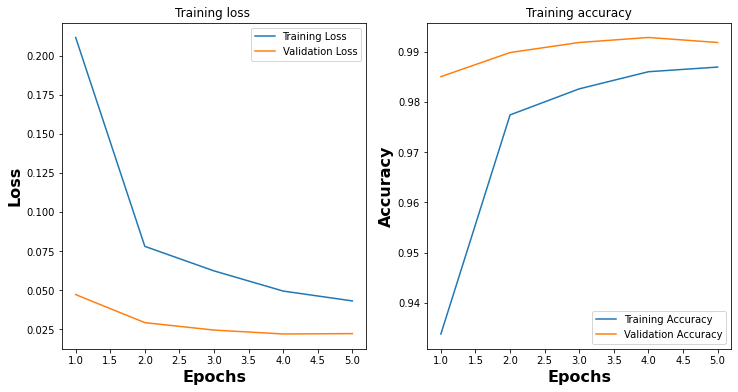

In [0]:
"""
Description: Plot model learning 
"""
Plot_model_training_parameters(history)

4.0 Prepare Data , Model and Label

In [0]:
"""
Description: Navigate to tensorflow saved format model using run id
"""
model_path = "runs:/"+run_id+"/MnistModelAIS"

In [0]:
import mlflow.pyfunc

In [0]:
"""
Description: Loading mlflow flavoured tensorflow model
"""
modelload = mlflow.pyfunc.load_model(model_path)

In [0]:
"""
Description: Save the model in .h5 format in local Databricks Directory
"""
model.save("/tmp/MNISTModelAIS1.h5")

In [0]:
"""
Description: Copy the saved model from local directory to the directory created by user
"""
dbutils.fs.cp("file:/tmp/MNISTModelAIS1.h5", "dbfs:/databricks/driver/modelais1/MNISTModeAiS.h5")
#dbutils.fs.put("./model/ModelMNIST.h5", model)

Out[33]: True

In [0]:
modelone=tf.keras.models.load_model("/dbfs/databricks/driver/modelais1/MNISTModeAiS.h5")

In [0]:
modelone.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                        

In [0]:
def save_data_label(x, y, n, data_path=mnist_data_path, label_path = mnist_label_path):
    """
    x: data
    y: label
    n: number of sample to save
    data_path= path to save data
    label_path = path to save label path
    """
    if len(y.shape)==2:
        y = np.argmax(y, axis=-1)
 
    label=pd.DataFrame()
    img_name = []
    img_label = [] 

    for i in tqdm(range(n)):
        cv2.imwrite("/dbfs/tmp/dataais"+str(i)+".jpg" ,x[i]*255.0) # don't use plt.imread otheriwse while loading the saved images , and passing to model there is accuarcy drop 
        img_name.append(str(i)+".jpg")
        img_label.append(y[i])
    label['image'] = img_name
    label["label"] = img_label

#     # write orig_label dataframe
    for i in tqdm(range(n)):
        dbutils.fs.cp("file:/dbfs/tmp/dataais"+str(i)+".jpg", "dbfs:/databricks/driver/dataais1/"+str(i)+".jpg")
    label.to_csv(('/dbfs/tmp/labelsais1.csv'),index=False)
    dbutils.fs.cp("file:/dbfs/tmp/labelsais1.csv", "dbfs:/databricks/driver/labelais1/label.csv")


In [0]:
"""
Description: save sample of data and label
"""
save_data_label(x = X_val, y= y_val, n=X_val.shape[0], data_path=mnist_data_path, label_path = mnist_label_path)

 21%|██▏  

*** WARNING: max output size exceeded, skipping output. ***

100%|██████████| 6000/6000 [15:22<00:00,  6.50it/s]


In [0]:
def make_archive(base_name,root_dir,zip_format='zip'):
    """
    created zip for given folder

    Parameters
    ----------
    base_name : name of zip file
    root_dir : directory to archive/zip
    zip_format : zip or tar 
        DESCRIPTION. The default is 'zip'.

    Returns
    -------
    None.

    """
    shutil.make_archive(base_name=base_name, format=zip_format, root_dir=root_dir)
    

In [0]:
"""
Description: Create a zip file Data, Label and Model Respectively by first saving it into local Databricks Directory and then copying it into the required directory created by the user
"""

"""
Description: Zip Data
"""

dataPath = "/dbfs/databricks/driver/dataais1"
zipPath= "/tmp/data"
shutil.make_archive(base_dir= dataPath, format='zip', base_name=zipPath)
StoragePath = "dbfs:/databricks/driver/zipais1/data.zip"
dbutils.fs.cp("file:" +zipPath + ".zip", StoragePath)

Out[39]: True

In [0]:
"""
Description: Zip Label
"""

labelPath = "/dbfs/databricks/driver/labelais1"
zipPath= "/tmp/label"
shutil.make_archive(base_dir= labelPath, format='zip', base_name=zipPath)
StoragePath = "dbfs:/databricks/driver/zipais1/label.zip"
dbutils.fs.cp("file:" +zipPath + ".zip", StoragePath)

Out[40]: True

In [0]:
"""
Description: Zip model
"""
model_encryption=0 #  0 if model is uploaded directly as a zip, 1 if model is encryted as .pyc and uploaded as a zip
if os.path.isfile(os.path.join(zip_path,"model.zip")):
    delete_directory(directorys=[os.path.join(zip_path,"model.zip")])
modelPath = "/dbfs/databricks/driver/modelais1/"
zipPath= "/tmp/model"
#shutil.make_archive(base_dir= modelPath, format='zip', base_name=zipPath)
make_archive(base_name=zipPath,root_dir=modelPath,zip_format='zip')
StoragePath = "dbfs:/databricks/driver/zipais1/model.zip"
dbutils.fs.cp("file:" +zipPath + ".zip", StoragePath)
# if model_encryption:
#     make_archive(base_name=os.path.join(zip_path,"model"),root_dir=pyc_model_path,zip_format='zip')
# else:
#     make_archive(base_name=os.path.join(zip_path,"model"),root_dir=model_path,zip_format='zip')

Out[41]: True

5.0 AIShield API Call

In [0]:
"""
Description: AIShield API URL and subscription key
""" 
url =  "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"  # provide api url here
org_id = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'  # provide org_id here
api_key = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"  # provide api_key here

In [0]:
"""
Description: Hit the AIShield API URL using the PyPi Package
""" 
client=ais.AIShieldApi(api_url=url, api_key=api_key, org_id=org_id)

In [0]:
"""
Description: Define the Task and Analysis Type
""" 
task_type = ais.get_type("task", "image_classification")
analysis_type = ais.get_type("analysis", "extraction")

In [0]:
"""
Description: Files path
"""
#data_path=os.path.join(zip_path,'mnist_data.zip')
data_path="/dbfs/databricks/driver/zipais1/data.zip"# full path of data zip
#label_path=os.path.join(zip_path,'mnist_label.zip') # full path of label zip
label_path="/dbfs/databricks/driver/zipais1/label.zip"
#model_path=os.path.join(zip_path,'mnist_model.zip')# full path of model zip
model_path="/dbfs/databricks/driver/zipais1/model.zip"
#model_path="/databricks/driver/zip/model.zip"

In [0]:
"""
Description: Perform model registration and upload the input artifacts
"""
status, job_details = client.register_model(task_type=task_type, analysis_type=analysis_type)
model_id = job_details.model_id
# print('Model id: {} \nInput artifacts will be uploaded as:\n data_upload_uri: {}\n label_upload_uri: {}'
#       '\n model_upload_uri: {}'.format(model_id, job_details.data_upload_uri, job_details.label_upload_uri,
#                                        job_details.model_upload_uri))

upload_status = client.upload_input_artifacts(job_details=job_details,
                                              data_path=data_path,
                                              label_path=label_path,
                                              model_path=model_path, )
print('Upload status: {}'.format(', '.join(upload_status)))

Upload status: data file upload successful, label file upload successful, model file upload successful


In [0]:
"""
Description: Specify the appropriate configs required for vulnerability analysis
"""

vuln_config = ais.VulnConfig(task_type=task_type,
                             analysis_type=analysis_type,
                             defense_generate=True)

vuln_config.input_dimensions = input_shape  # input dimension for mnist digit classification
vuln_config.number_of_classes = num_classes  # number of classes for mnist digit classification
vuln_config.attack_type = "blackbox"  # greybox or blackbox depending upon the availability of information about Model, Data and Parameters
vuln_config.number_of_attack_queries = 1000  # Number of attack queries to be generated for testing model vulnerability 
vuln_config.encryption_strategy = 0  # value 0 (or) 1, if model is unencrypted or encrypted(pyc) respectively
print('IC-Extraction parameters are: \n {} '.format(vuln_config.get_all_params()))

IC-Extraction parameters are: 
 {'attack_type': 'blackbox', 'defense_bestonly': 'no', 'encryption_strategy': 0, 'input_dimensions': '(28, 28, 1)', 'model_api_details': '', 'model_framework': 'tensorflow', 'normalize_data': 'yes', 'number_of_attack_queries': 1000, 'number_of_classes': 10, 'use_model_api': 'no', 'vulnerability_threshold': 0} 


In [1]:
"""
Description: Run vulnerability analysis
"""
my_status, job_details = client.vuln_analysis(model_id=model_id, vuln_config=vuln_config)
my_job_id = job_details.job_id
print('status: {} \nJob_id: {} '.format(my_status, my_job_id))

status: success 
Job_id: XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX 


In [2]:
"""
Description: Monitor progress for given Job ID using the Link below
"""
monitor_link= job_details.job_monitor_uri
print('Click on the URL to view Vulnerability Dashboard (GUI): {}'.format(monitor_link))

Click on the URL to view Vulnerability Dashboard (GUI): ##################################################


In [3]:
"""
Description: Fetch Job status using Job ID
"""
my_status = client.job_status (job_id = my_job_id)
print('job status ', my_status)

'\nDescription: Fetch Job status using Job ID\n'

In [0]:
def download_artifact(job_id: str, url: str, org_id: str, x_api_key: str, file_format: int = 0, report_type=None):
    """
    job_id: job_id  received after successful api call
    report_type: report to be downloaded
    file_format: change file_format to : 0- all report in zip
                        1- report in .txt
                        2- report in .pdf
                        3- report in .json
                        4- report in .xml
    """
    import requests
    import os
    import shutil
    #from clearml import Dataset, Task
    import zipfile
    import pickle
    import imp
    import numpy as np
    import pandas as pd
    def zip_extractor(file, extract_path=None, delete_zip=False):
        """
        extract zip file to the given path

        Parameters
        ----------
        file : path of zip file
        extract_path : path to extract zip file, default considered parent directory
        delete_zip: True, delete zip file after unzipping it

        Returns
        -------
        None.
        """
        if extract_path is None:
            extract_path = os.path.dirname(file)
        print("Extracting : {}".format(file))
        zf = zipfile.ZipFile(file=file, mode='r')
        zf.extractall(extract_path)
        zf.close()
        if delete_zip:
            os.remove(file)
            print("{} removed successfully.".format(file))

    report_path = "/dbfs/databricks/driver/Output_Artifacts"
    vulnerability_report = os.path.join(report_path, 'vulnerability_report')
    defense_report = os.path.join(report_path, 'defense_report')
    sample_data = os.path.join(report_path, 'sample_data')
    defense_artifact = os.path.join(report_path, 'defense_artifact')

    for path in [report_path, vulnerability_report, defense_report, sample_data, defense_artifact]:
        if os.path.isdir(path):
            if os.path.isfile(path):
                os.remove(path=path)
            else:
                shutil.rmtree(path=path)

        os.makedirs(path)

    reports_type = []
    if report_type is None:
        reports_type.append("Vulnerability")
        reports_type.append("Attack_samples")
        reports_type.append("Defense")
        reports_type.append("Defense_artifact")
        file_format = 0

    else:
        reports_type.append(report_type)

    for report_type in reports_type:
        print("received report_type : {} and file format is: {}".format(report_type, file_format))
        report_url = url + "/" + "get_report?job_id=" + str(
            job_id) + "&report_type=" + report_type + "&file_format=" + str(file_format)

        headers = {"org-id": org_id,
                   "x-api-key": x_api_key,
                   "Cache-Control": 'no-cache'
                   }
        headers1 = headers
        headers1["content-type"] = "application/zip"

        response = requests.request("GET", report_url, params={}, headers=headers1)

        if file_format == 0 or file_format == "Attack_samples":
            file_path = os.path.join(report_path, report_type + ".zip")
            with open(file_path, 'wb') as f:
                f.write(response.content)

            if report_type.lower() == "vulnerability".lower():
                zip_extractor(file=file_path, extract_path=vulnerability_report)
            elif report_type.lower() == "Attack_samples".lower():
                zip_extractor(file=file_path, extract_path=sample_data)
            elif report_type.lower() == "Defense".lower():
                zip_extractor(file=file_path, extract_path=defense_report)
            elif report_type.lower() == "Defense_artifact".lower():
                zip_extractor(file=file_path, extract_path=defense_artifact)

        elif file_format == 1:
            with open(os.path.join(report_path, report_type + ".txt"), 'wb') as f:
                f.write(response.content)
        elif file_format == 2:
            with open(os.path.join(report_path, report_type + ".pdf"), 'wb') as f:
                f.write(response.content)
        elif file_format == 3:
            with open(os.path.join(report_path, report_type + ".json"), 'wb') as f:
                f.write(response.content)
        elif file_format == 4:
            with open(os.path.join(report_path, report_type + ".xml"), 'wb') as f:
                f.write(response.content)

    
    # read vulnerability reports
    print("Reading vulnerability report: \n\n\n")
    f = open(os.path.join(vulnerability_report, "Vulnerability.txt"), "r")
    print(f.read())

    with mlflow.start_run(run_id=run_id):
            mlflow.log_artifact(vulnerability_report)

    print("Reading defense report: \n\n\n")
    f = open(os.path.join(defense_report, "Defense.txt"), "r")
    print(f.read())
    
    with mlflow.start_run(run_id=run_id):
        mlflow.log_artifact(defense_report)

    with mlflow.start_run(run_id=run_id):
            mlflow.log_artifact(sample_data)

    
#     # Description: Load defense model

    #defense_model_path = os.path.join(defense_artifact, 'defense_model.h5')

#     # saving model as artifact on clearml
    with mlflow.start_run(run_id=run_id):
        mlflow.log_artifact(defense_artifact)

    # save data to clearml server
#     artifact = Dataset.create(dataset_project="AIShield-pipeline-demos", dataset_name="AIShield-Artifact")
#     artifact.add_files(report_path)
#     artifact.finalize(auto_upload=True)
#     return artifact.id

In [4]:
artifact_id = download_artifact(my_job_id, url, org_id, api_key, file_format=0)

In [0]:
vuln_report=open("/dbfs/databricks/driver/Output_Artifacts/vulnerability_report/Vulnerability.json")

report=json.load(vuln_report)

print("Vulnerability Score",(report["Extracted Model Accuracy"]))
print("Original Model Accuracy", report['Original Model Accuracy'])

Vulnerability Score 0.23
Original Model Accuracy 0.99


In [0]:
"""
Description: loging parameters to mlflow
"""
with mlflow.start_run(run_id=run_id):
    mlflow.log_params(vuln_config.get_all_params())
    mlflow.log_param("job_id",my_job_id)
    mlflow.log_param("monitor_link",monitor_link)
    mlflow.log_metric("Vulnerability Score", report['Extracted Model Accuracy'])
    mlflow.log_metric("Original Model Accuracy", report['Original Model Accuracy'])

In [0]:
with mlflow.start_run(run_id=run_id):

    print("Active run id is : {}".format(run_id))

    defmodel=tf.keras.models.load_model("/dbfs/databricks/driver/reportsais/defense_artifact/defense_model.h5")

    class SklearnModelWrapper(mlflow.pyfunc.PythonModel):

          def __init__(self, model):

            self.model = model

    wrappedModel = SklearnModelWrapper(defmodel)

    conda_env =  _mlflow_conda_env(

        additional_conda_deps=None,

        additional_pip_deps=["cloudpickle=={}".format(cloudpickle.__version__), "scikit-learn=={}".format(sklearn.__version__)],

        additional_conda_channels=None,

    )

    
    mlflow.pyfunc.log_model("MnistModelAISDefense", python_model=wrappedModel, conda_env=conda_env)


    # get trained model path

    artifact_path=mlflow.get_artifact_uri('defmodel')

Active run id is : 472936035fd340e8b8c9dd02965ce96e
INFO:tensorflow:Assets written to: ram://88b6253b-7206-4595-ae35-1b1da73884c8/assets
INFO:tensorflow:Assets written to: ram://88b6253b-7206-4595-ae35-1b1da73884c8/assets


In [0]:
"""
Registering the Defence Model on model registry
"""

model_name = "MnistClassificationDefenseAIS"
model_version = mlflow.register_model(f"runs:/{run_id}/MnistModelAISDefense", model_name)
 
# Registering the model takes a few seconds, so add a small delay
time.sleep(15)

Registered model 'MnistClassificationDefenseAIS' already exists. Creating a new version of this model...
2023/03/30 08:53:15 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: MnistClassificationDefenseAIS, version 10
Created version '10' of model 'MnistClassificationDefenseAIS'.


In [0]:
"""
Pushing the Registered Defence model into Production Stage
"""

from mlflow.tracking import MlflowClient
 
client = MlflowClient()
client.transition_model_version_stage(
  name=model_name,
  version=model_version.version,
  stage="Production",
)

Out[63]: <ModelVersion: creation_timestamp=1680166395148, current_stage='Production', description='', last_updated_timestamp=1680166416434, name='MnistClassificationDefenseAIS', run_id='472936035fd340e8b8c9dd02965ce96e', run_link='', source='dbfs:/databricks/mlflow-tracking/1123443484504986/472936035fd340e8b8c9dd02965ce96e/artifacts/MnistModelAISDefense', status='READY', status_message='', tags={}, user_id='627414901360264', version='10'>

In [0]:
report_path = "/dbfs/databricks/driver/Output_Artifacts"
defense_artifact = os.path.join(report_path, 'defense_artifact')
sample_data = os.path.join(report_path, 'sample_data')

In [0]:
defense_model_path = os.path.join(defense_artifact, 'defense_model.h5')
defense_model = tf.keras.models.load_model(defense_model_path)
defense_model.summary()

Model: "model_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 original_img (InputLayer)   [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_240 (Conv2D)         (None, 26, 26, 16)        160       
                                                                 
 conv2d_241 (Conv2D)         (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_102 (MaxPooli  (None, 8, 8, 32)         0         
 ng2D)                                                           
                                                                 
 dense_148 (Dense)           (None, 8, 8, 64)          2112      
                                                                 
 global_max_pooling2d_74 (Gl  (None, 64)               0         
 obalMaxPooling2D)                                        

In [0]:
 '''
 Description: Use defense model
 ''' 
import importlib.machinery, importlib.util

module_path = os.path.join(defense_artifact, 'predict.py')

loader = importlib.machinery.SourceFileLoader("predict", module_path)
spec = importlib.util.spec_from_loader(loader.name, loader)
predict = importlib.util.module_from_spec(spec)
loader.exec_module(predict)    

defense = predict.AISDefenseModel(defense_model)

label, prob = defense.predict(X_val[:5])
print("original data:\nlabel: {} \nprob: {}".format(label, prob))


100%|██████████| 5/5 [00:00<00:00, 51275.11it/s]original data:
label: ['not-attack' 'not-attack' 'not-attack' 'not-attack' 'not-attack'] 
prob: [0.9813089  0.9894722  0.9607664  0.98324513 0.99381095]



In [0]:
def load_data(path):
    """
    path: load data from given path
    """
    files_path = get_file_path(path)
    x = []
    for file in files_path:
        img = cv2.imread(file, 0)
        x.append(img)
    x = np.expand_dims(np.array(x), axis=-1)
    return x

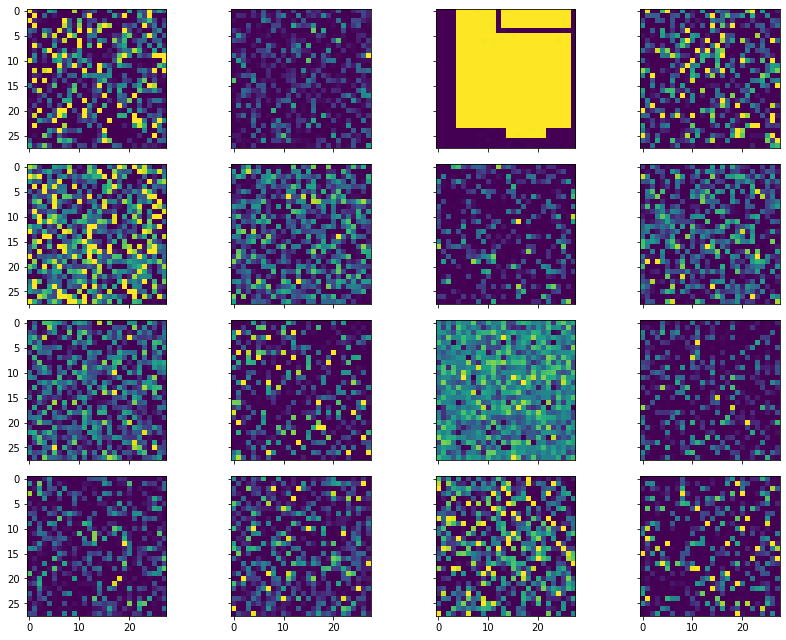

In [0]:
"""
Description: load attack data
"""
x_attack = load_data(path=sample_data)

plot(x=x_attack, row=4)

In [0]:
"""
Description: attack data to get prediction
"""
label, prob = defense.predict(x_attack[:5])
print("attack data:\nlabel: {} \nprob: {}".format(label, prob))

100%|██████████| 5/5 [00:00<00:00, 40563.87it/s]attack data:
label: ['attack' 'attack' 'attack' 'attack' 'attack'] 
prob: [1. 1. 1. 1. 1.]

